Getting inputs ready...

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [11]:
from google.colab.patches import cv2_imshow

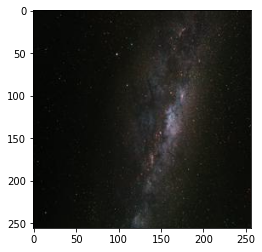

In [16]:
img = cv2.imread('/content/drive/MyDrive/unet-files/unet-files/train/1004.jpg')
plt.imshow(img)

In [21]:
# prepare data for training
# get images from train folder and resize them to 256 x 256 and gray scale them

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/unet-files/unet-files/train/'
# Path: unet_try1.ipynb
def get_data(path):
    images = []
    for image in os.listdir(path):
        img = cv2.imread(path + image)
        img = cv2.resize(img, (256, 256))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # view image
        # img = img/255
        # plt.imshow('image', img)
        img = img.reshape(128, 128, 3)
        images.append(img)

        
    images = np.array(images)
    
    return images

def get_output(path, size = 256):
    masks = []
    for image in os.listdir(path):
        img = cv2.imread(path + image)
        img = cv2.resize(img, (size, size))
        img = img.reshape(size, size, 3)
        masks.append(img)
        
    masks = np.array(masks)
    
    return masks


def save_grayscale(path, path2 = 'test/', size = 256):
    inputs = []
    #print(os.listdir(path))
    for image in os.listdir(path):
        #print(image)
        p = path+image
        #print(p)
        img = cv2.imread(p)
        # plt.imshow(img)
        #cv2_imshow('image', img)
        img = cv2.resize(img, (size, size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = img.reshape(size, size, 1)
        img = np.concatenate([img]*3, axis=-1)
        string="grey"
        inputs.append(img)
        cv2.imwrite(path2 + image , img)
    inputs = np.array(inputs)
    return inputs

    
path2 = '/content/drive/MyDrive/unet-files/unet-files/test/'
input = save_grayscale(path, path2, 64)
# # input = get_data(path2)
output = get_output(path, 64)


In [22]:
# save input and output arrays
np.save('/content/drive/MyDrive/unet-files/input.npy', input)
np.save('/content/drive/MyDrive/unet-files/output.npy', output)

loading data...

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
input = np.load('/content/drive/MyDrive/unet-files/input.npy')
output = np.load('/content/drive/MyDrive/unet-files/output.npy')

Defining the model...

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the ResNet decoder
def resnet_decoder(input_tensor, block):
    x = layers.ZeroPadding2D(padding=((1,0),(1,0)))(input_tensor)
    x = block(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid', name='conv5_block3')(x)
    x = block(filters=256, kernel_size=(3,3), strides=(2,2), padding='same', name='conv4_block6')(x)
    x = block(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='conv3_block4')(x)
    x = block(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='conv2_block3')(x)
    x = block(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', name='conv1_block2')(x)
    return x


# Define the UNet encoder
def unet_encoder(input_tensor, filters):
    c1 = layers.Conv2D(filters[0], (3, 3), activation='relu', padding='same')(input_tensor)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(filters[0], (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(filters[1], (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(filters[1], (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(filters[2], (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(filters[2], (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(filters[3], (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(filters[3], (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(filters[4], (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(filters[4], (3, 3), activation='relu', padding='same')(c5)

    return c5

# Define the inputs and outputs
input_tensor = layers.Input(shape=(128, 128, 1))
rgb_outputs = []

# Define the filters for the UNet encoder
filters = [32, 64, 128, 256, 512]

# Encode the input with UNet
unet_output = unet_encoder(input_tensor, filters)

#Decode the UNet output with ResNet
resnet_output = resnet_decoder(unet_output, layers.Conv2DTranspose)

#Extract RGB channels
red_output = layers.Conv2D(1, kernel_size=(1,1), activation='sigmoid')(resnet_output)
green_output = layers.Conv2D(1, kernel_size=(1,1), activation='sigmoid')(resnet_output)
blue_output = layers.Conv2D(1, kernel_size=(1,1), activation='sigmoid')(resnet_output)

#Define the model
model = models.Model(inputs=input_tensor, outputs=[red_output, green_output, blue_output])

#Print model summary
model.summary()

#Compile the model
model.compile(optimizer='adam', loss='mse')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_70 (Conv2D)             (None, 128, 128, 32  320         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_35 (BatchN  (None, 128, 128, 32  128        ['conv2d_70[0][0]']              
 ormalization)                  )                                                             

In [34]:
history=model.fit(input,output,batch_size=16,epochs=10)

Epoch 1/10


ValueError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, BatchNormalization, Activation, Softmax
from tensorflow.keras.models import Model

def unet_custom(input_size=(64, 64, 3)):
    # Encoder
    inputs = Input(input_size)
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    conv1 = x

    x = MaxPooling2D(pool_size=(2, 2))(conv1)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    conv2 = x

    x = MaxPooling2D(pool_size=(2, 2))(conv2)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    conv3 = x

    x = MaxPooling2D(pool_size=(2, 2))(conv3)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    conv4 = x

    x = MaxPooling2D(pool_size=(2, 2))(conv4)
    x = Conv2D(1024, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Decoder
    x = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(x)
    x = concatenate([x, conv4])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(x)
    x = concatenate([x, conv3])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(x)
    x = concatenate([x, conv2])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(x)
    x = concatenate([x, conv1])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    # now softmax output of 64x64x3 with axis=3
    outputs = Conv2D(3, 1, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model



In [ ]:
# Model Summary:
model = unet_custom()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['batch_normalization[0][0]']

In [ ]:
# save weights with highest validation accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('unet_64x64.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

model.fit(input, output, epochs=100, callbacks=[checkpoint, early])